<a href="https://colab.research.google.com/github/seyed-mohammadreza-mousavi/ml-playground-starter/blob/main/Naive_Bayes_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Naive Bayes Classifiers — Theory, Implementation, and Visualization

This notebook gives a practical, end‑to‑end tour of Naive Bayes classifiers.  
It includes the math, from‑scratch implementations (Gaussian, Multinomial, Bernoulli), comparisons with scikit‑learn, evaluation, and visualizations.

**Contents**
1. Intuition & Probabilistic Foundations  
2. Multinomial, Bernoulli, and Gaussian Naive Bayes — assumptions and use‑cases  
3. From‑scratch implementations (with Laplace smoothing)  
4. Synthetic & real datasets (Iris, Digits)  
5. Metrics: accuracy, precision, recall, F1, confusion matrix, ROC‑AUC (binary)  
6. Decision boundary visualizations for 2D cases  
7. Practical tips, pitfalls, and when Naive Bayes shines



## 1) Intuition & Probabilistic Foundations

We start from **Bayes’ theorem** for a class label $y \in \{1,\ldots,C\}$ and a feature vector $\mathbf{x} = (x_1,\ldots,x_d)$ as follows:

$$
P(y \mid \mathbf{x}) = \frac{P(\mathbf{x}\mid y)\,P(y)}{P(\mathbf{x})}
\;\propto\;
P(\mathbf{x}\mid y)\,P(y).
$$



\section*{Naive Bayes Formulation}

Naive Bayes assumes \textbf{conditional independence} of features given the class:
\begin{equation}
P(\mathbf{x} \mid y) = \prod_{j=1}^{d} P(x_j \mid y)
\end{equation}

We predict the \textbf{maximum a posteriori} (MAP) class:
\begin{equation}
\hat{y} = \arg\max_y \left[ \log P(y) + \sum_{j=1}^{d} \log P(x_j \mid y) \right]
\end{equation}

Taking logarithms avoids underflow and turns products into sums.

\subsection*{Class Prior}

\begin{equation}
\hat{P}(y=c) = \frac{N_c}{N}
\end{equation}

where \( N_c \) is the number of samples in class \( c \) and \( N \) is the total number of samples.

\subsection*{Likelihood Models}

Different Naive Bayes variants define \( P(x_j \mid y) \) differently.

\paragraph{Multinomial Naive Bayes (counts/frequencies, e.g., bag-of-words):}
\begin{equation}
P(\mathbf{x}\mid y=c)
  = \frac{\left(\sum_j x_j\right)!}{\prod_j x_j!}
    \prod_{j=1}^{d} \theta_{cj}^{\,x_j},
  \qquad
  \theta_{cj}
  = \frac{n_{cj} + \alpha}{\sum_{k=1}^{d} (n_{ck} + \alpha)}
\end{equation}

Here \( n_{cj} \) is the total count of feature \( j \) in class \( c \),
and \( \alpha \ge 0 \) is the Laplace (add-\( \alpha \)) smoothing parameter.

\paragraph{Bernoulli Naive Bayes (binary features: presence/absence):}
\begin{equation}
P(\mathbf{x}\mid y=c)
  = \prod_{j=1}^{d} \theta_{cj}^{x_j} (1-\theta_{cj})^{1-x_j},
  \qquad
  \theta_{cj} = \frac{n_{cj} + \alpha}{N_c + 2\alpha}
\end{equation}

where \( n_{cj} \) is the number of samples of class \( c \) where feature \( j = 1 \).

\paragraph{Gaussian Naive Bayes (continuous features):}
\begin{equation}
P(x_j \mid y=c)
  = \mathcal{N}(x_j;\, \mu_{cj}, \sigma_{cj}^2)
  = \frac{1}{\sqrt{2\pi\sigma_{cj}^2}}
    \exp\!\left[-\,\frac{(x_j - \mu_{cj})^2}{2\sigma_{cj}^2}\right]
\end{equation}

We estimate \( \mu_{cj} \) and \( \sigma_{cj}^2 \) from the data of class \( c \).

\subsection*{Decision Rule in Log-Space}

\begin{align}
\text{Multinomial: } &
\quad \log P(y=c)
  + \sum_j x_j \log \theta_{cj}
  + \text{const} \\[4pt]
\text{Bernoulli: } &
\quad \log P(y=c)
  + \sum_j \big[x_j \log \theta_{cj} + (1-x_j)\log(1-\theta_{cj})\big] \\[4pt]
\text{Gaussian: } &
\quad \log P(y=c)
  - \tfrac{1}{2}\sum_j
    \left[\log(2\pi\sigma_{cj}^2)
      + \frac{(x_j-\mu_{cj})^2}{\sigma_{cj}^2}\right]
\end{align}


In [1]:

# 2) Imports & Utility
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_digits, make_classification, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# Ensure reproducibility
rng = np.random.default_rng(42)



## 2) From‑Scratch Implementations

We implement minimal, numerically stable versions of Gaussian, Multinomial, and Bernoulli Naive Bayes.


In [2]:

class GaussianNB_Scratch:
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing
        self.classes_ = None
        self.theta_ = None  # means (n_classes, n_features)
        self.var_ = None    # variances (n_classes, n_features)
        self.class_count_ = None
        self.class_prior_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.classes_, y_idx = np.unique(y, return_inverse=True)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        self.theta_ = np.zeros((n_classes, n_features))
        self.var_ = np.zeros((n_classes, n_features))
        self.class_count_ = np.zeros(n_classes, dtype=float)
        for i, c in enumerate(self.classes_):
            Xc = X[y == c]
            self.class_count_[i] = Xc.shape[0]
            self.theta_[i] = Xc.mean(axis=0)
            # Variance with small smoothing to avoid division by zero
            self.var_[i] = Xc.var(axis=0) + self.var_smoothing
        self.class_prior_ = self.class_count_ / self.class_count_.sum()
        return self

    def _joint_log_likelihood(self, X):
        X = np.asarray(X, dtype=float)
        n_samples, n_features = X.shape
        n_classes = len(self.classes_)
        jll = np.zeros((n_samples, n_classes))
        for i in range(n_classes):
            mu = self.theta_[i]
            var = self.var_[i]
            # log-likelihood per feature under Gaussian
            log_prob = -0.5 * (np.log(2.0*np.pi*var) + ((X - mu) ** 2) / var).sum(axis=1)
            jll[:, i] = np.log(self.class_prior_[i]) + log_prob
        return jll

    def predict(self, X):
        jll = self._joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]

    def predict_proba(self, X):
        jll = self._joint_log_likelihood(X)
        # log-sum-exp normalization
        a = jll.max(axis=1, keepdims=True)
        probs = np.exp(jll - a)
        probs /= probs.sum(axis=1, keepdims=True)
        return probs


In [3]:

class MultinomialNB_Scratch:
    def __init__(self, alpha=1.0):
        self.alpha = float(alpha)
        self.classes_ = None
        self.class_count_ = None
        self.feature_count_ = None  # counts per class-feature
        self.feature_log_prob_ = None
        self.class_log_prior_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        if (X < 0).any():
            raise ValueError("MultinomialNB requires nonnegative features (counts/frequencies).")
        self.classes_, y_idx = np.unique(y, return_inverse=True)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        self.class_count_ = np.zeros(n_classes, dtype=float)
        self.feature_count_ = np.zeros((n_classes, n_features), dtype=float)
        for i, c in enumerate(self.classes_):
            Xc = X[y == c]
            self.class_count_[i] = Xc.shape[0]
            self.feature_count_[i] = Xc.sum(axis=0)
        # Laplace smoothing
        smoothed_fc = self.feature_count_ + self.alpha
        smoothed_cc = smoothed_fc.sum(axis=1, keepdims=True)
        self.feature_log_prob_ = np.log(smoothed_fc) - np.log(smoothed_cc)
        self.class_log_prior_ = np.log(self.class_count_) - np.log(self.class_count_.sum())
        return self

    def _jll(self, X):
        X = np.asarray(X, dtype=float)
        return self.class_log_prior_ + X @ self.feature_log_prob_.T

    def predict(self, X):
        jll = self._jll(X)
        return self.classes_[np.argmax(jll, axis=1)]

    def predict_proba(self, X):
        jll = self._jll(X)
        a = jll.max(axis=1, keepdims=True)
        probs = np.exp(jll - a)
        probs /= probs.sum(axis=1, keepdims=True)
        return probs


In [4]:

class BernoulliNB_Scratch:
    def __init__(self, alpha=1.0, binarize_threshold=0.0):
        self.alpha = float(alpha)
        self.binarize_threshold = binarize_threshold
        self.classes_ = None
        self.class_count_ = None
        self.feature_prob_ = None  # theta_{cj}
        self.class_log_prior_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        # Binarize
        Xb = (X > self.binarize_threshold).astype(float)
        self.classes_, y_idx = np.unique(y, return_inverse=True)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        self.class_count_ = np.zeros(n_classes, dtype=float)
        feature_on = np.zeros((n_classes, n_features), dtype=float)
        for i, c in enumerate(self.classes_):
            Xc = Xb[y == c]
            self.class_count_[i] = Xc.shape[0]
            feature_on[i] = Xc.sum(axis=0)
        # Laplace smoothing for Bernoulli
        self.feature_prob_ = (feature_on + self.alpha) / (self.class_count_.reshape(-1,1) + 2*self.alpha)
        self.class_log_prior_ = np.log(self.class_count_) - np.log(self.class_count_.sum())
        return self

    def _jll(self, X):
        X = np.asarray(X, dtype=float)
        Xb = (X > self.binarize_threshold).astype(float)
        # log p(x|y) = sum_j [ x_j log theta + (1-x_j) log (1-theta) ]
        log_theta = np.log(self.feature_prob_)
        log_1_minus = np.log(1 - self.feature_prob_)
        jll = []
        for i in range(len(self.classes_)):
            ll = (Xb * log_theta[i] + (1 - Xb) * log_1_minus[i]).sum(axis=1)
            jll.append(self.class_log_prior_[i] + ll)
        return np.vstack(jll).T

    def predict(self, X):
        jll = self._jll(X)
        return self.classes_[np.argmax(jll, axis=1)]

    def predict_proba(self, X):
        jll = self._jll(X)
        a = jll.max(axis=1, keepdims=True)
        probs = np.exp(jll - a)
        probs /= probs.sum(axis=1, keepdims=True)
        return probs



## 3) Experiments on Real and Synthetic Data

We demonstrate:
- **Gaussian NB** on Iris (continuous features),
- **Multinomial NB** on Digits (nonnegative counts/intensities; we rescale to integer‑like counts),
- **Bernoulli NB** on binarized Digits,
- Decision boundaries on synthetic 2D data.


In [5]:

# Iris — Gaussian NB (from-scratch vs scikit-learn)
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

gnb_s = GaussianNB_Scratch().fit(X_train, y_train)
y_pred_s = gnb_s.predict(X_test)

gnb = GaussianNB().fit(X_train, y_train)
y_pred_lib = gnb.predict(X_test)

acc_s = accuracy_score(y_test, y_pred_s)
acc_lib = accuracy_score(y_test, y_pred_lib)
print("Iris — GaussianNB Scratch accuracy:", acc_s)
print("Iris — GaussianNB (sklearn) accuracy:", acc_lib)

cm = confusion_matrix(y_test, y_pred_lib)
print("Confusion matrix (sklearn GaussianNB):\n", cm)


Iris — GaussianNB Scratch accuracy: 0.9111111111111111
Iris — GaussianNB (sklearn) accuracy: 0.9111111111111111
Confusion matrix (sklearn GaussianNB):
 [[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]


In [6]:

# Digits — Multinomial NB (counts-like features)
digits = load_digits()
Xd, yd = digits.data, digits.target

# Scale to [0, 1], then multiply to get pseudo-counts (integers) suitable for Multinomial
scaler = MinMaxScaler()
Xd01 = scaler.fit_transform(Xd)
Xd_counts = np.round(Xd01 * 10.0)  # small counts to keep it simple

Xtr, Xte, ytr, yte = train_test_split(Xd_counts, yd, test_size=0.3, random_state=42, stratify=yd)

mnb_s = MultinomialNB_Scratch(alpha=1.0).fit(Xtr, ytr)
yp_s = mnb_s.predict(Xte)

mnb = MultinomialNB(alpha=1.0).fit(Xtr, ytr)
yp_lib = mnb.predict(Xte)

print("Digits — MultinomialNB Scratch accuracy:", accuracy_score(yte, yp_s))
print("Digits — MultinomialNB (sklearn) accuracy:", accuracy_score(yte, yp_lib))
print("Confusion matrix (sklearn MultinomialNB):\n", confusion_matrix(yte, yp_lib))


Digits — MultinomialNB Scratch accuracy: 0.8759259259259259
Digits — MultinomialNB (sklearn) accuracy: 0.8759259259259259
Confusion matrix (sklearn MultinomialNB):
 [[52  0  0  0  2  0  0  0  0  0]
 [ 0 37  8  0  0  1  1  0  4  4]
 [ 0  3 48  0  0  0  0  0  2  0]
 [ 0  0  1 51  0  0  0  1  2  0]
 [ 0  0  0  0 51  0  0  2  1  0]
 [ 0  0  0  0  1 41  0  1  0 12]
 [ 0  2  0  0  0  0 52  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0  7  0  0  0  0  0  1 44  0]
 [ 0  1  0  1  0  0  0  6  3 43]]


In [7]:

# Digits — Bernoulli NB (binarized pixels)
bin_thresh = 0.5
binarizer = Binarizer(threshold=bin_thresh)
Xd_bin = binarizer.fit_transform(Xd01)

Xtr_b, Xte_b, ytr_b, yte_b = train_test_split(Xd_bin, yd, test_size=0.3, random_state=42, stratify=yd)

bnb_s = BernoulliNB_Scratch(alpha=1.0, binarize_threshold=0.0).fit(Xtr_b, ytr_b)
ypb_s = bnb_s.predict(Xte_b)

bnb = BernoulliNB(alpha=1.0).fit(Xtr_b, ytr_b)
ypb_lib = bnb.predict(Xte_b)

print("Digits — BernoulliNB Scratch accuracy:", accuracy_score(yte_b, ypb_s))
print("Digits — BernoulliNB (sklearn) accuracy:", accuracy_score(yte_b, ypb_lib))
print("Confusion matrix (sklearn BernoulliNB):\n", confusion_matrix(yte_b, ypb_lib))


Digits — BernoulliNB Scratch accuracy: 0.8759259259259259
Digits — BernoulliNB (sklearn) accuracy: 0.8759259259259259
Confusion matrix (sklearn BernoulliNB):
 [[50  0  0  0  2  0  2  0  0  0]
 [ 0 42  4  0  0  1  1  0  5  2]
 [ 0  4 48  0  0  0  0  0  1  0]
 [ 0  1  0 46  0  0  0  3  1  4]
 [ 0  2  0  0 50  0  0  1  1  0]
 [ 0  0  0  0  0 46  0  0  0  9]
 [ 0  1  0  0  0  0 52  0  1  0]
 [ 0  0  0  0  0  0  0 53  1  0]
 [ 0  8  3  0  0  1  0  1 38  1]
 [ 0  0  0  0  0  0  0  4  2 48]]



## 4) Visualizations

We’ll plot decision boundaries for 2D synthetic datasets to build intuition.  
(Each chart is a separate figure, uses matplotlib only, and does not set explicit colors.)


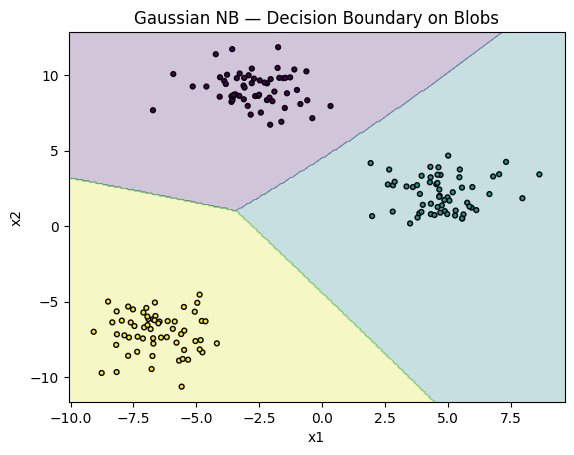

In [8]:

# Helper for decision boundary plots
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=12, edgecolor="k")
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()

# Gaussian NB on blobs
Xb, yb = make_blobs(n_samples=600, centers=3, cluster_std=1.3, random_state=42)
Xtr_b2, Xte_b2, ytr_b2, yte_b2 = train_test_split(Xb, yb, test_size=0.3, random_state=42, stratify=yb)

gnb_vis = GaussianNB_Scratch().fit(Xtr_b2, ytr_b2)
plot_decision_boundary(gnb_vis, Xte_b2, yte_b2, "Gaussian NB — Decision Boundary on Blobs")


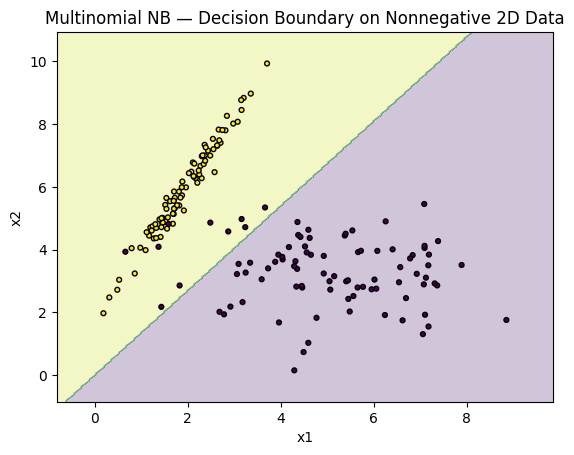

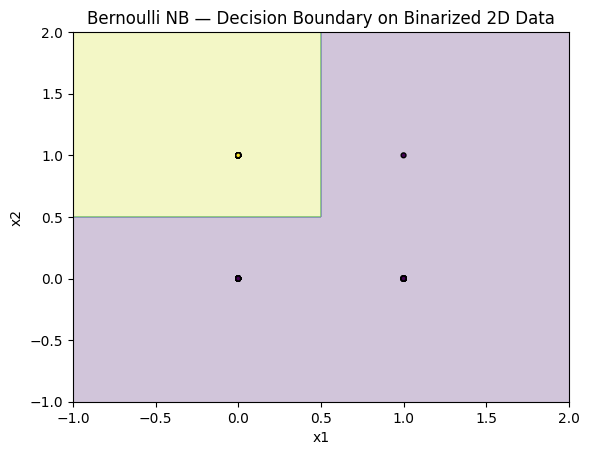

In [9]:

# Multinomial & Bernoulli demo on nonnegative 2D data
# We'll synthesize nonnegative features for illustration.
X_pos, y_pos = make_classification(n_samples=600, n_features=2, n_informative=2, n_redundant=0,
                                   n_clusters_per_class=1, random_state=7)
X_pos = MinMaxScaler().fit_transform(X_pos) * 10.0  # scale to nonnegative counts-like
Xtr_p, Xte_p, ytr_p, yte_p = train_test_split(X_pos, y_pos, test_size=0.3, random_state=42, stratify=y_pos)

mnb_vis = MultinomialNB_Scratch(alpha=1.0).fit(Xtr_p, ytr_p)
plot_decision_boundary(mnb_vis, Xte_p, yte_p, "Multinomial NB — Decision Boundary on Nonnegative 2D Data")

# Bernoulli (binarize features)
Xb2 = (X_pos > 5.0).astype(float)
Xtr_bb, Xte_bb, ytr_bb, yte_bb = train_test_split(Xb2, y_pos, test_size=0.3, random_state=42, stratify=y_pos)

bnb_vis = BernoulliNB_Scratch(alpha=1.0, binarize_threshold=0.5).fit(Xtr_bb, ytr_bb)
plot_decision_boundary(bnb_vis, Xte_bb, yte_bb, "Bernoulli NB — Decision Boundary on Binarized 2D Data")



## 5) Metrics & Analysis

We’ll compute accuracy, precision, recall, and F1.  
For binary problems we’ll also show ROC‑AUC and a ROC curve example.


Binary Iris — GaussianNB Scratch
Accuracy: 1.0
Precision: 1.0 Recall: 1.0 F1: 1.0
ROC-AUC: 1.0
Confusion Matrix:
 [[15  0]
 [ 0 15]]


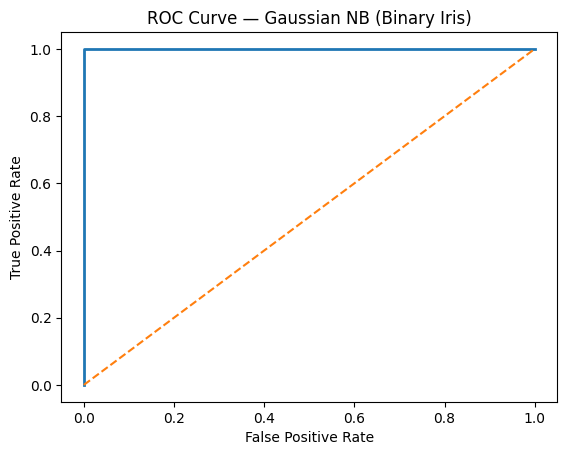

In [10]:

# Binary ROC example using a 2-class subset of Iris
mask = y < 2  # classes 0 and 1
X_bin, y_bin = X[mask], y[mask]

Xtr_bi, Xte_bi, ytr_bi, yte_bi = train_test_split(X_bin, y_bin, test_size=0.3, random_state=42, stratify=y_bin)

gnb_bin = GaussianNB_Scratch().fit(Xtr_bi, ytr_bi)
proba = gnb_bin.predict_proba(Xte_bi)[:, 1]
yp_bin = gnb_bin.predict(Xte_bi)

acc = accuracy_score(yte_bi, yp_bin)
prec, rec, f1, _ = precision_recall_fscore_support(yte_bi, yp_bin, average="binary", zero_division=0)
auc = roc_auc_score(yte_bi, proba)
cm = confusion_matrix(yte_bi, yp_bin)

print("Binary Iris — GaussianNB Scratch")
print("Accuracy:", acc)
print("Precision:", prec, "Recall:", rec, "F1:", f1)
print("ROC-AUC:", auc)
print("Confusion Matrix:\n", cm)

# ROC curve
fpr, tpr, thr = roc_curve(yte_bi, proba)
plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve — Gaussian NB (Binary Iris)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.show()



## 6) Practical Tips & Pitfalls

- **When to use which variant:**  
  Multinomial for count data (e.g., bag‑of‑words), Bernoulli for binary features (presence/absence), Gaussian for continuous features.
- **Laplace/Add‑\(\alpha\) smoothing** prevents zero probabilities when a feature never appears with a class.
- **Feature scaling:** Gaussian NB does **not** require standardization (it models feature‑wise variances), but extreme scaling differences may impact numerical stability.
- **Correlated features:** The naive conditional‑independence assumption is often violated; NB can still perform well, but heavy correlation can degrade performance.
- **Imbalanced classes:** Adjust priors or use class‑balanced training; evaluate with precision/recall and ROC‑AUC.
- **Text classification:** Convert text to **counts** or **TF‑IDF** (for Multinomial NB). (This notebook avoids external downloads for offline reproducibility.)
